# 📌 NYC Restaurant Inspection Risk Prediction

### 🧪 Modeling

In this notebook, we will:

1. **Perform hyperparameter tuning** on four models: Logistic Regression, Decision Tree, Random Forest, and Gradient Boosting, optimizing parameters based on the validation set.

2. **Evaluate two scenarios:** one excluding `violation_code`, a variable highly predictive of the target—and one including it.

3. **Select the best model and scenario** by comparing performance metrics to identify the most suitable approach for this task.

### Dependencies

In [88]:
import sys
import optuna
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from os.path import join, abspath
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score

# adding the root folder to the system path
if abspath('..') not in sys.path:
    sys.path.append(abspath('..'))

from src.path_manager import PathManager

# path manager to handle paths
path_manager = PathManager()
processed_data_path = path_manager.processed_data_path
models_path = path_manager.models_path

# ignore warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
# import data
processed_train = pd.read_csv(join(processed_data_path, 'processed_train.csv')).set_index('key')
processed_val = pd.read_csv(join(processed_data_path, 'processed_val.csv')).set_index('key')
processed_test = pd.read_csv(join(processed_data_path, 'processed_test.csv')).set_index('key')

# separate target and features
target_feature = 'critical_flag'

X_train = processed_train.drop(target_feature, axis=1)
y_train = processed_train[target_feature]

X_val = processed_val.drop(target_feature, axis=1)
y_val = processed_val[target_feature]

X_test = processed_test.drop(target_feature, axis=1)
y_test = processed_test[target_feature]


full_len = len(X_train) + len(X_val) + len(X_test)
print(
    f'Train: {X_train.shape} -> {round(len(X_train)/full_len*100)}%',
    f'\nValidation: {X_val.shape} -> {round(len(X_val)/full_len*100)}%'
    f'\nTest: {X_test.shape} -> {round(len(X_test)/full_len*100)}%',
)

display(X_train.head(3))

Train: (64286, 15) -> 69% 
Validation: (14388, 15) -> 15%
Test: (14433, 15) -> 16%


,dba,building,street,zipcode,cuisine_description,score,inspection_month,inspection_year,inspection_type_other,desc_length_chars,critical_token_count,negative_sentiment,tfidf_cleaning,tfidf_food,violation_code
key,,,,,,,,,,,,,,,
30075445_31-01-23_10D,0.609112,0.754557,0.791582,0.611277,0.444058,0.435218,0.0,0.888889,0.0,0.252874,0.000000,1.0,0.0,0.000000,3.828669e-16
30075445_31-01-23_06D,0.609112,0.754557,0.791582,0.611277,0.444058,0.435218,0.0,0.888889,0.0,0.139573,0.384615,1.0,0.0,0.066933,1.000000e+00
30075445_31-01-23_04N,0.609112,0.754557,0.791582,0.611277,0.444058,0.435218,0.0,0.888889,0.0,0.270936,0.923077,1.0,0.0,0.073791,1.000000e+00


In [3]:
# separate X sets per scenario
X_train_1 = X_train.copy().drop(columns=['violation_code'])
X_val_1 = X_val.copy().drop(columns=['violation_code'])
X_test_1 = X_test.copy().drop(columns=['violation_code'])

X_train_2 = X_train.copy()
X_val_2 = X_val.copy()
X_test_2 = X_test.copy()

### Baseline Models

In [4]:
def classification_model_df(model_list, X_val, y_val):
    '''
    Creates a DataFrame with classification metrics for each model.

    Args:
        model_list (list): List of fitted model instances
        tree_list (list): List of tree-based models (use raw features)
        train (DataFrame): Training features
        test (DataFrame): Test features (raw)
        scaled_test (DataFrame): Scaled test features
        target_test (Series): True labels for test set

    Returns:
        DataFrame: Classification metrics per model
    '''
    
    df = pd.DataFrame(columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1', 'ROC AUC'])

    for i, model in enumerate(model_list):
        try:

            # Predict
            y_pred = model.predict(X_val)

            # Compute metrics
            accuracy = accuracy_score(y_val, y_pred)
            recall = recall_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred)
            roc = roc_auc_score(y_val, y_pred)

            df.loc[i] = [
                model.__class__.__name__,
                round(accuracy, 4),
                round(recall, 4),
                round(precision, 4),
                round(f1, 4),
                round(roc, 4)
            ]

        except Exception as e:
            print(f'Error with {model.__class__.__name__}:\n{e}')

    return df.sort_values(by='F1', ascending=False).reset_index(drop=True)

In [39]:
# model set
seed = 42

LR_1 = LogisticRegression(random_state=seed).fit(X_train_1, y_train)
DT_1 = DecisionTreeClassifier(random_state=seed).fit(X_train_1, y_train)
RF_1 = RandomForestClassifier(random_state=seed).fit(X_train_1, y_train)
GB_1 = GradientBoostingClassifier(random_state=seed).fit(X_train_1, y_train)

LR_2 = LogisticRegression(random_state=seed).fit(X_train_2, y_train)
DT_2 = DecisionTreeClassifier(random_state=seed).fit(X_train_2, y_train)
RF_2 = RandomForestClassifier(random_state=seed).fit(X_train_2, y_train)
GB_2 = GradientBoostingClassifier(random_state=seed).fit(X_train_2, y_train)

In [40]:
model_list_1 = [LR_1, DT_1, RF_1, GB_1]
model_list_2 = [LR_2, DT_2, RF_2, GB_2]

# baseline
print('Validation Baseline Models Results for Scenario 1 (without violation_code)')
baseline_1 = classification_model_df(model_list_1, X_val=X_val_1, y_val=y_val)
display(baseline_1)

print('Validation Baseline Models Results for Scenario 2 (with violation_code)')
baseline_2 = classification_model_df(model_list_2, X_val=X_val_2, y_val=y_val)
display(baseline_2)

Validation Baseline Models Results for Scenario 1 (without violation_code)


,Model,Accuracy,Recall,Precision,F1,ROC AUC
0,GradientBoostingClassifier,0.9958,0.9948,0.9979,0.9963,0.9960
1,DecisionTreeClassifier,0.9874,0.9990,0.9794,0.9891,0.9855
2,RandomForestClassifier,0.9848,0.9933,0.9804,0.9868,0.9835
3,LogisticRegression,0.9213,0.9005,0.9590,0.9289,0.9247


Validation Baseline Models Results for Scenario 2 (with violation_code)


,Model,Accuracy,Recall,Precision,F1,ROC AUC
0,RandomForestClassifier,0.9993,0.9988,1.0000,0.9994,0.9994
1,DecisionTreeClassifier,0.9992,0.9991,0.9994,0.9993,0.9992
2,LogisticRegression,0.9990,0.9982,1.0000,0.9991,0.9991
3,GradientBoostingClassifier,0.9990,0.9991,0.9990,0.9991,0.9989


### Hyperparameter Tuning

Results were similar, but almost perfect with `violation_code` and slightly better than without, as expected. Let's dive further.

In [7]:
def get_classification_metrics(model, train_x, test_x, val_x, train_y, test_y, val_y): 
    ''' 
    Gets classification metrics for train, validation, and test sets
    '''
    pred_train = model.predict(train_x)
    pred_val = model.predict(val_x)
    pred_test = model.predict(test_x)

    # train metrics
    train_acc = accuracy_score(train_y, pred_train)
    train_precision = precision_score(train_y, pred_train)
    train_recall = recall_score(train_y, pred_train)
    train_f1 = f1_score(train_y, pred_train)
    train_roc = roc_auc_score(train_y, pred_train)

    # validation metrics
    val_acc = accuracy_score(val_y, pred_val)
    val_precision = precision_score(val_y, pred_val)
    val_recall = recall_score(val_y, pred_val)
    val_f1 = f1_score(val_y, pred_val)
    val_roc = roc_auc_score(val_y, pred_val)

    # test metrics
    test_acc = accuracy_score(test_y, pred_test)
    test_precision = precision_score(test_y, pred_test)
    test_recall = recall_score(test_y, pred_test)
    test_f1 = f1_score(test_y, pred_test)
    test_roc = roc_auc_score(test_y, pred_test)

    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'],
        'Train': [train_acc, train_precision, train_recall, train_f1, train_roc],
        'Validation': [val_acc, val_precision, val_recall, val_f1, val_roc],
        'Test': [test_acc, test_precision, test_recall, test_f1, test_roc]
    })

    return metrics_df

def grid_best_params(model, model_params):
    '''
    Returns Grid Search best parameters for input classification model  
    
    Args:
        model (sklearn classifier)
        model_params (dict)
    
    Returns: 
        dict - best parameters
    '''
    grid_search = GridSearchCV(model, model_params, cv=3, scoring='f1', verbose=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_

def manual_tuning(model, parameter, values_range, train_X, train_y, test_X, test_y):
    train_results = []
    test_results = []
    
    current_best_score = -1
    best_test_value = None

    for val in values_range:
        params = {parameter: val}
        instance = model.set_params(**params)
        instance.fit(train_X, train_y)

        train_pred = instance.predict(train_X)
        test_pred = instance.predict(test_X)

        train_score = f1_score(train_y, train_pred)
        test_score = f1_score(test_y, test_pred)

        train_results.append(train_score)
        test_results.append(test_score)

        if test_score > current_best_score:
            best_test_value = val
            current_best_score = test_score

    parameter_name = parameter.replace('_', ' ').capitalize()
    print(f'The best value for \033[1m{parameter_name} is {best_test_value} with F1 Score: {round(current_best_score, 3)}')

    plt.figure(figsize=(10, 5))
    plt.plot(values_range, train_results, 'gray', label='Train F1-Score', linewidth=3)
    plt.plot(values_range, test_results, 'yellowgreen', label='Test F1-Score', linewidth=3)
    plt.vlines(x=best_test_value, ymin=min(train_results + test_results), 
                ymax=max(train_results + test_results), colors='red', linestyle='--', label='Best F1')

    plt.xticks(values_range)
    plt.ylabel('F1-Score', fontweight='bold', fontsize=10)
    plt.xlabel(parameter_name, fontweight='bold', fontsize=15)
    plt.legend(fontsize=10)
    plt.grid(linewidth=.35)
    sns.despine()
    plt.show()

    return best_test_value

def cv_manual_tuning(model, parameter, values_range, train_X, train_y, val_X, val_y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    train_results = []
    test_results = []
    
    current_best_score = -1
    best_test_value = None

    for val in values_range:
        params = {parameter: val}
        instance = model.set_params(**params)

        fold_train_scores = []
        fold_test_scores = []

        for train_idx, val_idx in kf.split(val_X):
            X_train_fold, X_val_fold = val_X.iloc[train_idx], val_X.iloc[val_idx]
            y_train_fold, y_val_fold = val_y.iloc[train_idx], val_y.iloc[val_idx]

            instance.fit(X_train_fold, y_train_fold)

            train_pred = instance.predict(X_train_fold)
            val_pred = instance.predict(X_val_fold)

            train_score = f1_score(y_train_fold, train_pred)
            val_score = f1_score(y_val_fold, val_pred)

            fold_train_scores.append(train_score)
            fold_test_scores.append(val_score)

        mean_train_score = np.mean(fold_train_scores)
        mean_test_score = np.mean(fold_test_scores)

        train_results.append(mean_train_score)
        test_results.append(mean_test_score)

        if mean_test_score > current_best_score:
            best_test_value = val
            current_best_score = mean_test_score

    parameter_name = parameter.replace('_', ' ').capitalize()
    print(f'The best value for \033[1m{parameter_name} is {best_test_value} with F1 Score: {round(current_best_score, 3)}')

    plt.figure(figsize=(10, 5))
    values_range = ['none' if v is None else v for v in values_range]

    plt.plot(values_range, train_results, 'gray', label='Train F1-Score', linewidth=3)
    plt.plot(values_range, test_results, 'yellowgreen', label='Validation F1-Score', linewidth=3)
    plt.vlines(x=best_test_value, ymin=min(train_results + test_results), 
                ymax=max(train_results + test_results), colors='red', linestyle='--', label='Best F1')

    plt.xticks(values_range)
    plt.ylabel('F1-Score', fontweight='bold', fontsize=10)
    plt.xlabel(parameter_name, fontweight='bold', fontsize=15)
    plt.legend(fontsize=10)
    plt.grid(linewidth=.35)
    sns.despine()
    plt.show()

    return best_test_value


In [62]:
def tune_model_optuna(
    model_key,
    X_train, y_train,
    X_val,   y_val,
    n_trials=50,
    random_state=42
):
    """
    Run Optuna to maximize F1 on a held‐out validation set.

    Args:
        model_key (str): One of ['lr','dt','rf','gb']
        X_train, y_train: Training features & labels
        X_val,   y_val:   Validation features & labels
        n_trials (int):   Number of Optuna trials
        random_state (int): Seed for reproducibility

    Returns:
        dict: best_params
        float: best F1 on validation set
    """

    def objective(trial):
        # --- define hyper‐parameter search space per model ---
        if model_key == 'lr':
            model = LogisticRegression(
                C=trial.suggest_loguniform('C', 1e-4, 1e2),
                penalty=trial.suggest_categorical('penalty', ['l1', 'l2', None]),
                solver='saga',
                random_state=random_state,
                max_iter=10_000,
                n_jobs=-1
            )

        elif model_key == 'dt':
            model = DecisionTreeClassifier(
                max_depth=trial.suggest_categorical('max_depth', [None, 5, 10, 15, 20, 30, 50, 70, 100]),
                max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                min_samples_split=trial.suggest_int('min_samples_split', 2, 20),
                min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 13),
                splitter=trial.suggest_categorical('splitter', ['best', 'random']),
                criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
                random_state=random_state
            )

        elif model_key == 'rf':
            model = RandomForestClassifier(
                n_estimators=trial.suggest_int('n_estimators', 50, 500),
                max_depth=trial.suggest_categorical('max_depth', [None] + list(range(1,16))),
                max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
                min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 13),
                criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
                random_state=random_state,
                n_jobs=-1
            )

        elif model_key == 'gb':
            model = GradientBoostingClassifier(
                n_estimators=trial.suggest_categorical('n_estimators', list(range(700, 1100, 100))),
                max_depth=trial.suggest_int('max_depth', 2, 10),
                min_samples_leaf=trial.suggest_categorical('min_samples_leaf', list(range(2, 42, 10))),
                min_samples_split=trial.suggest_categorical('min_samples_split', list(range(2, 252, 50))),
                max_features=trial.suggest_categorical('max_features', [None, 'sqrt', 'log2']),
                subsample=trial.suggest_uniform('subsample', 0.8, 1.0),
                learning_rate=trial.suggest_categorical('learning_rate', [0.1, 0.05]),
                random_state=random_state
            )
        
        else:
            raise ValueError(f'Unknown model_key: {model_key}')

        # --- train on train set, evaluate on val set ---
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        return f1_score(y_val, preds)

    # create and run study
    study = optuna.create_study(
        sampler=optuna.samplers.TPESampler(seed=random_state),
        direction='maximize'
    )
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    return study.best_params, study.best_value

#### Scenario 1

In [ ]:
tuning_results = {}
for model_key in ['lr', 'dt', 'rf']:
    if model_key == 'dt':
        n_trials = 50
    else:
        n_trials = 20

    params, score = tune_model_optuna(
        model_key=model_key,
        X_train=X_train_1,
        y_train=y_train,
        X_val=X_val_1,
        y_val=y_val,
        n_trials=n_trials
    )
    tuning_results[model_key] = params, score

[I 2025-06-10 14:16:58,876] A new study created in memory with name: no-name-b9be27e3-5abd-446e-915a-4f8d2f2bf4d0


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-10 14:16:59,134] Trial 0 finished with value: 0.9263531499556344 and parameters: {'C': 0.017670169402947963, 'penalty': 'l1'}. Best is trial 0 with value: 0.9263531499556344.
[I 2025-06-10 14:17:09,636] Trial 1 finished with value: 0.9421570470639845 and parameters: {'C': 0.0008632008168602552, 'penalty': None}. Best is trial 1 with value: 0.9421570470639845.
[I 2025-06-10 14:17:20,082] Trial 2 finished with value: 0.9421570470639845 and parameters: {'C': 0.4042872735027334, 'penalty': None}. Best is trial 1 with value: 0.9421570470639845.
[I 2025-06-10 14:17:30,966] Trial 3 finished with value: 0.9422160942592128 and parameters: {'C': 9.877700294007917, 'penalty': 'l1'}. Best is trial 3 with value: 0.9422160942592128.
[I 2025-06-10 14:17:31,377] Trial 4 finished with value: 0.9241042763580326 and parameters: {'C': 0.006690421166498805, 'penalty': 'l1'}. Best is trial 3 with value: 0.9422160942592128.
[I 2025-06-10 14:17:42,716] Trial 5 finished with value: 0.942157047063984

[I 2025-06-10 14:19:10,138] A new study created in memory with name: no-name-7d81743c-ef4d-4c78-882c-ea655f424743


[I 2025-06-10 14:19:10,137] Trial 19 finished with value: 0.8302036199095023 and parameters: {'C': 0.0009063906295520836, 'penalty': 'l2'}. Best is trial 3 with value: 0.9422160942592128.


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-10 14:19:10,175] Trial 0 finished with value: 0.9219765076448586 and parameters: {'max_depth': 5, 'max_features': None, 'min_samples_split': 17, 'min_samples_leaf': 3, 'splitter': 'random', 'criterion': 'entropy'}. Best is trial 0 with value: 0.9219765076448586.
[I 2025-06-10 14:19:10,209] Trial 1 finished with value: 0.9421215994157386 and parameters: {'max_depth': 70, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 3, 'splitter': 'random', 'criterion': 'gini'}. Best is trial 1 with value: 0.9421215994157386.
[I 2025-06-10 14:19:10,277] Trial 2 finished with value: 0.9603701945894637 and parameters: {'max_depth': 70, 'max_features': 'sqrt', 'min_samples_split': 12, 'min_samples_leaf': 3, 'splitter': 'best', 'criterion': 'gini'}. Best is trial 2 with value: 0.9603701945894637.
[I 2025-06-10 14:19:10,303] Trial 3 finished with value: 0.9219765076448586 and parameters: {'max_depth': 5, 'max_features': None, 'min_samples_split': 4, 'min_samples_leaf': 11, '

[I 2025-06-10 14:19:15,082] A new study created in memory with name: no-name-3ebe419a-93e0-4bd9-93e0-f0120ac496bd


[I 2025-06-10 14:19:14,953] Trial 48 finished with value: 0.9330703808702083 and parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 6, 'splitter': 'random', 'criterion': 'gini'}. Best is trial 5 with value: 0.9990863129682646.
[I 2025-06-10 14:19:15,079] Trial 49 finished with value: 0.9992082343626286 and parameters: {'max_depth': None, 'max_features': None, 'min_samples_split': 20, 'min_samples_leaf': 2, 'splitter': 'best', 'criterion': 'entropy'}. Best is trial 49 with value: 0.9992082343626286.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-10 14:19:16,506] Trial 0 finished with value: 0.9649337910740559 and parameters: {'n_estimators': 218, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9649337910740559.
[I 2025-06-10 14:19:20,262] Trial 1 finished with value: 0.9989641094387911 and parameters: {'n_estimators': 255, 'max_depth': 9, 'max_features': None, 'min_samples_split': 4, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 1 with value: 0.9989641094387911.
[I 2025-06-10 14:19:22,352] Trial 2 finished with value: 0.9219765076448586 and parameters: {'n_estimators': 296, 'max_depth': 1, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 13, 'criterion': 'gini'}. Best is trial 1 with value: 0.9989641094387911.
[I 2025-06-10 14:19:23,518] Trial 3 finished with value: 0.9968392900559202 and parameters: {'n_estimators': 52, 'max_depth': 15, 'max_features': None, 'min_samples_split': 8, 'min_sa

In [13]:
def tune_gb_model(model, params, X_train, y_train, X_val, y_val, best_params=None, param_type=None):
    '''Fine tunes a gradient boosting model using iterative grid search.'''
    assert param_type in ['int64', 'float64', 'str'], 'param_type must be int, float, or str'

    model.set_params(**best_params) if best_params else None

    # track results manually
    results = []

    for param_set in tqdm(list(ParameterGrid(params))):
        model.set_params(**param_set)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        score = f1_score(y_val, y_pred)

        results.append({
            **param_set,
            'f1_score': score
        })

    # check results
    search_df = pd.DataFrame(results)

    search_df = search_df.sort_values('f1_score', ascending=False).reset_index(drop=True)
    display(search_df.head())

    # update best params
    top_result = search_df.iloc[[0]]
    
    param_names = list(params.keys())
    for param_name in param_names:
        if top_result[param_name].values[0] != None:
            top_result[param_name] = top_result[param_name].astype(param_type)

        if param_type == 'str':
            try:
                top_result[param_name] = top_result[param_name].astype(param_type)
            except:
                top_result[param_name] = top_result[param_name].astype('int64')

    if not best_params:
        best_params = {}

    best_params.update({k: search_df[k].values[0] for k in params})
    best_score = top_result['f1_score']

    return best_params, best_score

In [11]:
# gradient boosting
params = {
    'n_estimators': range(700, 1100, 100),
}

# define model
model = GradientBoostingClassifier(
    learning_rate=0.1,
    min_samples_split=100,
    min_samples_leaf=32,
    max_depth=7, # allow deeper trees
    max_features='sqrt',
    random_state=42
)

best_params, best_score = tune_gb_model(
    model=model,
    params=params,
    X_train=X_train_1,
    y_train=y_train,
    X_val=X_val_1,
    y_val=y_val,
    best_params=None,
    param_type='int64'
)

print(best_params)
print(best_score)

  0%|          | 0/4 [00:00<?, ?it/s]

,n_estimators,f1_score
0,900,0.999209
1,1000,0.999209
2,800,0.999087
3,700,0.999026


{'n_estimators': np.int64(900)}
0    0.999209
Name: f1_score, dtype: float64


In [12]:
params = {
            'max_depth': list(range(2,9)),
}

# define model
model = GradientBoostingClassifier(
    learning_rate=0.1,
    min_samples_split=100,
    min_samples_leaf=32,
    max_features='sqrt',
    random_state=42
)

best_params, best_score = tune_gb_model(
    model=model,
    params=params,
    X_train=X_train_1,
    y_train=y_train,
    X_val=X_val_1,
    y_val=y_val,
    best_params=best_params,
    param_type='int64'
)

print(best_params)
print(best_score)

  0%|          | 0/8 [00:00<?, ?it/s]

,max_depth,f1_score
0,7,0.999209
1,6,0.999026
2,8,0.999026
3,5,0.998782
4,4,0.998599


{'n_estimators': np.int64(900), 'max_depth': np.int64(7)}
0    0.999209
Name: f1_score, dtype: float64


In [21]:
params = {
            'min_samples_leaf':range(2, 42, 10)
}

# define model
model = GradientBoostingClassifier(
    learning_rate=0.1,
    min_samples_split=100,
    max_features='sqrt',
    random_state=42
)

best_params, best_score = tune_gb_model(
    model=model,
    params=params,
    X_train=X_train_1,
    y_train=y_train,
    X_val=X_val_1,
    y_val=y_val,
    best_params=best_params,
    param_type='int64'
)

print(best_params)
print(best_score)

  0%|          | 0/4 [00:00<?, ?it/s]

,min_samples_leaf,f1_score
0,2,0.999269
1,12,0.999209
2,32,0.999209
3,22,0.999087


{'n_estimators': np.int64(900), 'max_depth': np.int64(7), 'min_samples_leaf': np.int64(2)}
0    0.999269
Name: f1_score, dtype: float64


In [25]:
params = {
            'min_samples_split': range(2, 252, 50)
}

# define model
model = GradientBoostingClassifier(
    learning_rate=0.1,
    max_features='sqrt',
    random_state=42
)

best_params, best_score = tune_gb_model(
    model=model,
    params=params,
    X_train=X_train_1,
    y_train=y_train,
    X_val=X_val_1,
    y_val=y_val,
    best_params=best_params,
    param_type='int64'
)

print(best_params)
print(best_score)

  0%|          | 0/5 [00:00<?, ?it/s]

,min_samples_split,f1_score
0,102,0.999391
1,52,0.999208
2,202,0.999087
3,152,0.999087
4,2,0.999087


{'n_estimators': np.int64(900), 'max_depth': np.int64(7), 'min_samples_leaf': np.int64(2), 'min_samples_split': np.int64(102)}
0    0.999391
Name: f1_score, dtype: float64


In [30]:
params = {
            'max_features': [None, 'sqrt', 'log2'] + list(range(10, len(X_train_1.columns), 1))
}
# None makes max_features = n_features

# define model
model = GradientBoostingClassifier(
    learning_rate=0.1,
    random_state=42
)

best_params, best_score = tune_gb_model(
    model=model,
    params=params,
    X_train=X_train_1,
    y_train=y_train,
    X_val=X_val_1,
    y_val=y_val,
    best_params=best_params,
    param_type='str'
)

print(best_params)
print(best_score)

  0%|          | 0/7 [00:00<?, ?it/s]

,max_features,f1_score
0,10,0.999452
1,None,0.999391
2,sqrt,0.999391
3,log2,0.999391
4,12,0.999391


{'n_estimators': np.int64(900), 'max_depth': np.int64(7), 'min_samples_leaf': np.int64(2), 'min_samples_split': np.int64(102), 'max_features': 10}
0    0.999452
Name: f1_score, dtype: float64


In [45]:
# init the classifier with best parameters
GB1 = GradientBoostingClassifier(learning_rate=0.1, random_state=42).set_params(**best_params).fit(X_train_1, y_train)

gb_1 = classification_model_df([GB1], X_val=X_val_1, y_val=y_val)
display(gb_1)

,Model,Accuracy,Recall,Precision,F1,ROC AUC
0,GradientBoostingClassifier,0.9994,0.9993,0.9996,0.9995,0.9994


In [ ]:
# now allow model to learn slower, lr/2, n_estimators*2
GB2 =  GradientBoostingClassifier(learning_rate=0.05, random_state=42).set_params(**best_params).set_params(**{'n_estimators':best_params['n_estimators'] * 2}).fit(X_train_1, y_train)

gb_2 = classification_model_df([GB2], X_val=X_val_1, y_val=y_val)
display(gb_2)

,Model,Accuracy,Recall,Precision,F1,ROC AUC
0,GradientBoostingClassifier,0.9992,0.9991,0.9995,0.9993,0.9992


**GB2 seems tohave oferfitted the data**. LR = 0.1 is deemed as optimal.

In [127]:
# save gb best params
best_params.update({'learning_rate':0.1, 'random_state':42})
best_bg_results = float(gb_1.iloc[0]['F1'])

tuning_results['gb'] = (best_params, best_bg_results)

tuning_results_df =pd.DataFrame(tuning_results).T.rename(columns={0:'best_params', 1:'best_score'}).reset_index().rename(columns={'index':'model'})

tuning_results_df.drop(columns=['best_params']).sort_values('best_score', ascending=False)

,model,best_score
3,gb,0.9995
1,dt,0.999208
2,rf,0.999087
0,lr,0.942216


#### Scenario 2

In [63]:
tuning_results_2 = {}
for model_key in ['lr', 'dt', 'rf', 'gb']:
    if model_key == 'dt':
        n_trials = 50
    elif model_key == 'lr':
        n_trials = 10
    else:
        n_trials = 20

    params, score = tune_model_optuna(
        model_key=model_key,
        X_train=X_train_2,
        y_train=y_train,
        X_val=X_val_2,
        y_val=y_val,
        n_trials=n_trials
    )
    tuning_results_2[model_key] = params, score

[I 2025-06-10 15:45:29,113] A new study created in memory with name: no-name-f61a8e7b-316c-4ae5-b25c-ab67d75e6549


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-06-10 15:45:29,305] Trial 0 finished with value: 0.999086090294279 and parameters: {'C': 0.017670169402947963, 'penalty': 'l1'}. Best is trial 0 with value: 0.999086090294279.
[I 2025-06-10 15:46:00,935] Trial 1 finished with value: 0.9991476926823328 and parameters: {'C': 0.0008632008168602552, 'penalty': None}. Best is trial 1 with value: 0.9991476926823328.
[I 2025-06-10 15:46:31,436] Trial 2 finished with value: 0.9991476926823328 and parameters: {'C': 0.4042872735027334, 'penalty': None}. Best is trial 1 with value: 0.9991476926823328.
[I 2025-06-10 15:46:46,471] Trial 3 finished with value: 0.9992693619094009 and parameters: {'C': 9.877700294007917, 'penalty': 'l1'}. Best is trial 3 with value: 0.9992693619094009.
[I 2025-06-10 15:46:46,646] Trial 4 finished with value: 0.999086090294279 and parameters: {'C': 0.006690421166498805, 'penalty': 'l1'}. Best is trial 3 with value: 0.9992693619094009.
[I 2025-06-10 15:47:19,954] Trial 5 finished with value: 0.9991476926823328 a

[I 2025-06-10 15:47:20,888] A new study created in memory with name: no-name-4f6a4fca-6773-42fa-b7f8-af75a41e6ec7


[I 2025-06-10 15:47:20,886] Trial 9 finished with value: 0.999086090294279 and parameters: {'C': 0.006724850206557251, 'penalty': 'l2'}. Best is trial 3 with value: 0.9992693619094009.


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-10 15:47:20,932] Trial 0 finished with value: 0.999086090294279 and parameters: {'max_depth': 5, 'max_features': None, 'min_samples_split': 17, 'min_samples_leaf': 3, 'splitter': 'random', 'criterion': 'entropy'}. Best is trial 0 with value: 0.999086090294279.
[I 2025-06-10 15:47:20,953] Trial 1 finished with value: 0.9988420988481931 and parameters: {'max_depth': 70, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 3, 'splitter': 'random', 'criterion': 'gini'}. Best is trial 0 with value: 0.999086090294279.
[I 2025-06-10 15:47:20,988] Trial 2 finished with value: 0.9989651184026298 and parameters: {'max_depth': 70, 'max_features': 'sqrt', 'min_samples_split': 12, 'min_samples_leaf': 3, 'splitter': 'best', 'criterion': 'gini'}. Best is trial 0 with value: 0.999086090294279.
[I 2025-06-10 15:47:21,012] Trial 3 finished with value: 0.9989643618641486 and parameters: {'max_depth': 5, 'max_features': None, 'min_samples_split': 4, 'min_samples_leaf': 11, 'spli

[I 2025-06-10 15:47:22,873] A new study created in memory with name: no-name-1af30709-0751-4ed8-ac7b-b7d7b329e558


[I 2025-06-10 15:47:22,870] Trial 49 finished with value: 0.999330207635633 and parameters: {'max_depth': 70, 'max_features': None, 'min_samples_split': 13, 'min_samples_leaf': 2, 'splitter': 'random', 'criterion': 'entropy'}. Best is trial 45 with value: 0.999452188203786.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-10 15:47:24,072] Trial 0 finished with value: 0.9992691839220463 and parameters: {'n_estimators': 218, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9992691839220463.
[I 2025-06-10 15:47:26,075] Trial 1 finished with value: 0.998965370336559 and parameters: {'n_estimators': 255, 'max_depth': 9, 'max_features': None, 'min_samples_split': 4, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9992691839220463.
[I 2025-06-10 15:47:27,914] Trial 2 finished with value: 0.999086090294279 and parameters: {'n_estimators': 296, 'max_depth': 1, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 13, 'criterion': 'gini'}. Best is trial 0 with value: 0.9992691839220463.
[I 2025-06-10 15:47:28,763] Trial 3 finished with value: 0.9992085235920852 and parameters: {'n_estimators': 52, 'max_depth': 15, 'max_features': None, 'min_samples_split': 8, 'min_samp

[I 2025-06-10 15:47:53,717] A new study created in memory with name: no-name-273f0d31-40ea-4eca-a43d-ae31f7a02a3b


[I 2025-06-10 15:47:53,715] Trial 19 finished with value: 0.999086090294279 and parameters: {'n_estimators': 351, 'max_depth': 2, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 9 with value: 0.9993302891933029.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-10 15:48:14,511] Trial 0 finished with value: 0.9992086199549522 and parameters: {'n_estimators': 800, 'max_depth': 3, 'min_samples_leaf': 22, 'min_samples_split': 102, 'max_features': 'log2', 'subsample': 0.9049512863264476, 'learning_rate': 0.1}. Best is trial 0 with value: 0.9992086199549522.
[I 2025-06-10 15:48:58,405] Trial 1 finished with value: 0.9991477964450938 and parameters: {'n_estimators': 700, 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 202, 'max_features': None, 'subsample': 0.8195344228012769, 'learning_rate': 0.1}. Best is trial 0 with value: 0.9992086199549522.
[I 2025-06-10 15:49:29,865] Trial 2 finished with value: 0.9991476926823328 and parameters: {'n_estimators': 1000, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 52, 'max_features': 'sqrt', 'subsample': 0.8391965724838291, 'learning_rate': 0.05}. Best is trial 0 with value: 0.9992086199549522.
[I 2025-06-10 15:49:55,351] Trial 3 finished with value: 0.9992085235920852 and

In [125]:
tuning_results_df_2=pd.DataFrame(tuning_results_2).T.rename(columns={0:'best_params', 1:'best_score'}).reset_index().rename(columns={'index':'model'}).sort_values('best_score', ascending=False)

tuning_results_df_2.drop(columns=['best_params']).sort_values('best_score', ascending=False)

,model,best_score
1,dt,0.999452
2,rf,0.99933
3,gb,0.99933
0,lr,0.999269


### Results

#### Compare Best Model per Scenario

- In scenario 1, the best model was **Gradient Boosting** manually tuned.
- In scenario 2, the best model was **Decision Tree** optuna tuned.

It seems the presence of `violation_code` allows a simple tree-based model like Decision Tree to accuratelly classify `critical_flag`. Let's see how these models perform on the test set.

In [81]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [83]:
def make_confusion_matrix(
    cf,
    group_names = None,
    categories ='auto',
    count = True,
    percent = True,
    cbar = True,
    xyticks = True,
    xyplotlabels = True,
    sum_stats = True,
    figsize = None,
    cmap = 'Blues',
    title = None
):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    
    Args: 
        cf -           Confusion matrix to be passed in
        group_names -  List of strings that represent the labels row by row to be shown in each square
        categories -   List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
        count -        If True, show the raw number in the confusion matrix. Default is True
        normalize -    If True, show the proportions for each category. Default is True
        cbar -         If True, show the color bar. The cbar values are based off the values in the confusion matrix. Default is True
        xyticks -      If True, show x and y ticks. Default is True
        xyplotlabels - If True, show 'True Label' and 'Predicted Label' on the figure. Default is True
        sum_stats -    If True, display summary statistics below the figure. Default is True
        figsize -      Tuple representing the figure size. Default will be the matplotlib rcParams value
        cmap -         Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
        title -        Title for the heatmap. Default is None
        
    Returns: 
        Confusion Matrix Plot
    '''
    # Generating text inside each matrix square
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ['{}\n'.format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ['{0:0.0f}\n'.format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ['{0:.2%}'.format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f'{v1}{v2}{v3}'.strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # Generating summary statistics & text for summary stats
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = '\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}'.format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = '\n\nAccuracy={:0.3f}'.format(accuracy)
    else:
        stats_text = ''

    # Setting figure parameters according to other arguments
    if figsize == None:
        # Gets default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks == False:
        # Doesn't show categories if xyticks is False
        categories = False

    # Making the heatmap vizualization
    plt.figure(figsize = figsize)
    ax = sns.heatmap(
        cf, 
        annot = box_labels, fmt = '',
        cmap = cmap, cbar = cbar,
        xticklabels = categories,
        yticklabels = categories
    )

    if xyplotlabels:
        plt.ylabel('True label', fontsize = 14)
        plt.xlabel('Predicted label' + stats_text, fontsize = 14)
    else:
        plt.xlabel(stats_text, fontsize = 14)
    
    if title:
        plt.title(title)

def performance_metrics(y_Train, y_PredTrain, y_Test, y_PredTest):
    '''
    Creates Dataframe with the main benchmark metrics for Classfication models
    
    Args: 
        y_Train -      Series with target values used to train model
        y_PredTrain -  Series with predicted values from y_Train
        y_Test -       Series with test values used to validate model
        y_PredTest -   Series with predicted values from y_Test
        
    Returns: 
        pandas.core.frame.DataFrame
    '''
    # Columns
    measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
    
    # Results for train data
    train_results = [
        round(metrics.accuracy_score(y_Train, y_PredTrain),4),  # Calculating accuracy
        round(metrics.precision_score(y_Train, y_PredTrain),4),  # Calculating precision
        round(metrics.recall_score(y_Train, y_PredTrain),4),  # Calculating recall
        round(metrics.f1_score(y_Train, y_PredTrain),4),  # Calculating f1 score
        round(metrics.roc_auc_score(y_Train, y_PredTrain),4)  # Calculating ROC area under the curve
    ]
    # Results for test data
    test_results = [
        round(metrics.accuracy_score(y_Test, y_PredTest),4),  # Calculating accuracy
        round(metrics.precision_score(y_Test, y_PredTest),4),  # Calculating precision
        round(metrics.recall_score(y_Test, y_PredTest),4),  # Calculating recall
        round(metrics.f1_score(y_Test, y_PredTest),4),  # Calculating f1 score
        round(metrics.roc_auc_score(y_Test, y_PredTest),4)  # Calculating ROC area under the curve
    ]
    
    results = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test': test_results})
    
    # Comparison column
    results['Difference'] = round(results['Train'] - results['Test'], 4) 
    
    return results

In [77]:
best_scenario_1_params = tuning_results['gb'][0]
best_scenario_2_params = tuning_results_2['dt'][0]
best_scenario_2_params.update({'random_state':42})

# create and fit models
GB1 = GradientBoostingClassifier(**best_scenario_1_params).fit(X_train_1, y_train)
DT2 = DecisionTreeClassifier(**best_scenario_2_params).fit(X_train_2, y_train)

# set labels
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

# target categories
categories = ['Not Critical', 'Critical']

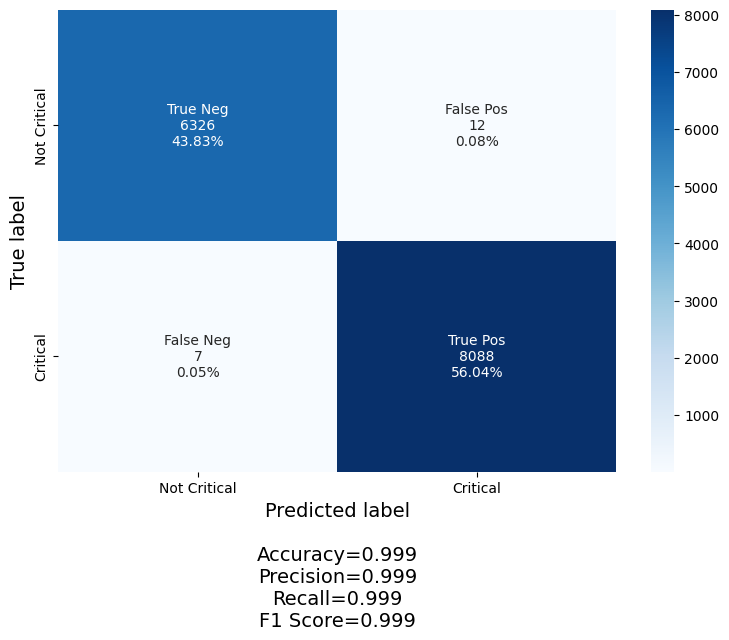

              precision    recall  f1-score   support

Not Critical       1.00      1.00      1.00      6338
    Critical       1.00      1.00      1.00      8095

    accuracy                           1.00     14433
   macro avg       1.00      1.00      1.00     14433
weighted avg       1.00      1.00      1.00     14433



Overfit Check:


,Measure,Train,Test,Difference
0,ACCURACY,1.0,0.9987,0.0013
1,PRECISION,1.0,0.9985,0.0015
2,RECALL,1.0,0.9991,0.0009
3,F1 SCORE,1.0,0.9988,0.0012
4,AUC,1.0,0.9986,0.0014


In [99]:
y_pred = GB1.predict(X_test_1)
y_pred_train = GB1.predict(X_train_1)

# get model scores
value_train = round(GB1.score(X_train_1, y_train), 3)
value_test = round(GB1.score(X_test_1, y_test), 3)

# plot confusion matrix
cf = metrics.confusion_matrix(y_test, y_pred)
make_confusion_matrix(
    cf, 
    group_names = labels,
    categories = categories,
    figsize = (9,6)
)
plt.show()

# create classification report
print(classification_report(y_test, y_pred, target_names = categories))

# dataframe report
print('\n\nOverfit Check:')
display(performance_metrics(y_train, y_pred_train, y_test, y_pred))

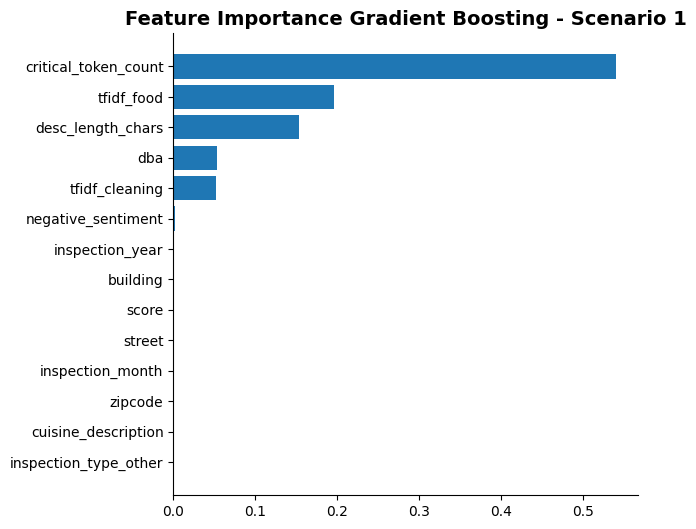

In [98]:
# get feature importance
feature_importance = GB1.feature_importances_

# get feature names
feature_names = GB1.feature_names_in_

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance}).sort_values('importance')

# plot feature importance
plt.figure(figsize=(6, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.title('Feature Importance Gradient Boosting - Scenario 1', fontsize=14, fontweight='bold')
sns.despine()
plt.show()

In [119]:
# check performance on violation code "09A"
# only one that both "Not Critical" & "Critical"
y_pred = GB1.predict(X_test_1)
y_pred_df = pd.DataFrame({'y_pred': y_pred}, index=y_test.index)
tmp = pd.concat([y_test, y_pred_df], axis=1)
tmp =  tmp.reset_index().rename(columns={target_feature: 'y_true'})
tmp['violation_code'] = tmp.key.str.split('_').str[-1]
tmp_subset = tmp.loc[tmp['violation_code'] == '09A'].copy()
tmp_subset['correct'] = tmp_subset['y_true'] == tmp_subset['y_pred']
print(tmp_subset['correct'].value_counts(), end='\n\n')

accuracy = accuracy_score(tmp_subset['y_true'], tmp_subset['y_pred'])
f1 = f1_score(tmp_subset['y_true'], tmp_subset['y_pred'], average='weighted')  # or 'macro' depending on your class balance
report = classification_report(tmp_subset['y_true'], tmp_subset['y_pred'])

print('Subset Accuracy (09A):', accuracy)
print('Subset F1 Score (09A):', f1)
print('\n\nClassification Report:\n', report)

correct
True     30
False    18
Name: count, dtype: int64

Subset Accuracy (09A): 0.625
Subset F1 Score (09A): 0.642578125


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.66      0.72        35
           1       0.37      0.54      0.44        13

    accuracy                           0.62        48
   macro avg       0.58      0.60      0.58        48
weighted avg       0.68      0.62      0.64        48



---

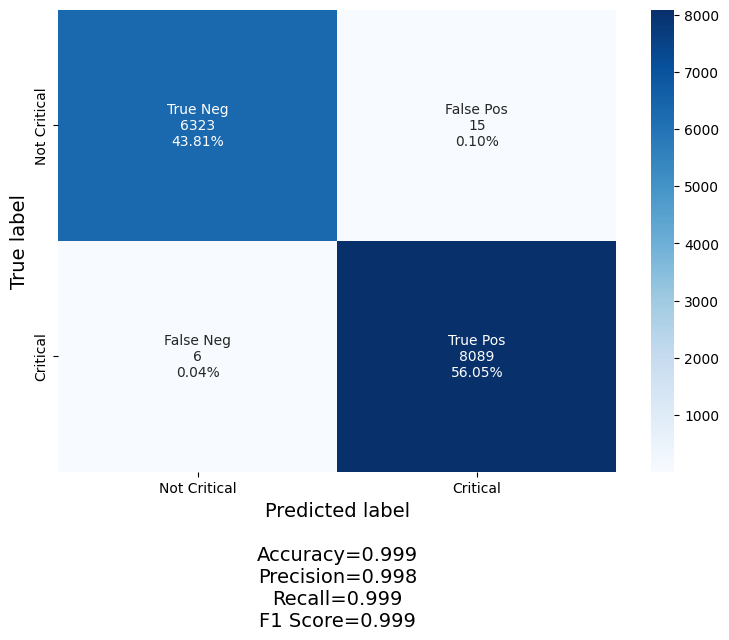

              precision    recall  f1-score   support

Not Critical       1.00      1.00      1.00      6338
    Critical       1.00      1.00      1.00      8095

    accuracy                           1.00     14433
   macro avg       1.00      1.00      1.00     14433
weighted avg       1.00      1.00      1.00     14433



Overfit Check:


,Measure,Train,Test,Difference
0,ACCURACY,0.9997,0.9985,0.0012
1,PRECISION,0.9998,0.9981,0.0017
2,RECALL,0.9997,0.9993,0.0004
3,F1 SCORE,0.9998,0.9987,0.0011
4,AUC,0.9997,0.9984,0.0013


In [84]:
y_pred = DT2.predict(X_test_2)
y_pred_train = DT2.predict(X_train_2)

# get model scores
value_train = round(DT2.score(X_train_2, y_train), 3)
value_test = round(DT2.score(X_test_2, y_test), 3)

# plot confusion matrix
cf = metrics.confusion_matrix(y_test, y_pred)
make_confusion_matrix(
    cf, 
    group_names = labels,
    categories = categories,
    figsize = (9,6)
)
plt.show()

# create classification report
print(classification_report(y_test, y_pred, target_names = categories))

# dataframe report
print('\n\nOverfit Check:')
display(performance_metrics(y_train, y_pred_train, y_test, y_pred))

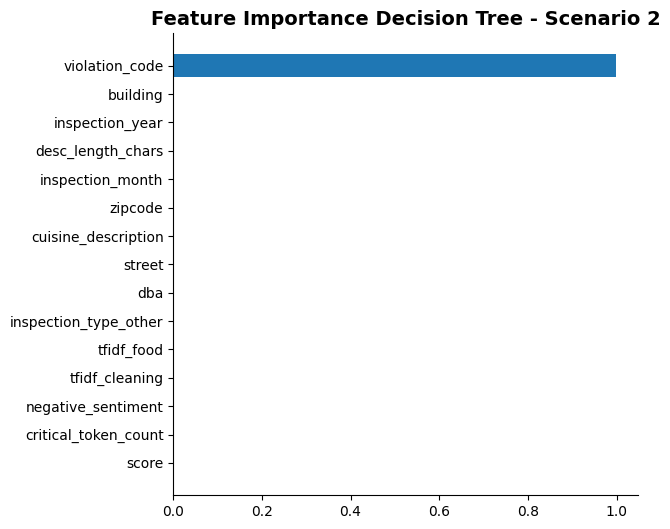

In [96]:
# get feature importance
feature_importance = DT2.feature_importances_

# get feature names
feature_names = DT2.feature_names_in_

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance}).sort_values('importance')

# plot feature importance
plt.figure(figsize=(6, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.title('Feature Importance Decision Tree - Scenario 2', fontsize=14, fontweight='bold')
sns.despine()
plt.show()

In [120]:
# check performance on violation code "09A"
# only one that both "Not Critical" & "Critical"
y_pred = DT2.predict(X_test_2)
y_pred_df = pd.DataFrame({'y_pred': y_pred}, index=y_test.index)
tmp = pd.concat([y_test, y_pred_df], axis=1)
tmp =  tmp.reset_index().rename(columns={target_feature: 'y_true'})
tmp['violation_code'] = tmp.key.str.split('_').str[-1]
tmp_subset = tmp.loc[tmp['violation_code'] == '09A'].copy()
tmp_subset['correct'] = tmp_subset['y_true'] == tmp_subset['y_pred']
print(tmp_subset['correct'].value_counts(), end='\n\n')

accuracy = accuracy_score(tmp_subset['y_true'], tmp_subset['y_pred'])
f1 = f1_score(tmp_subset['y_true'], tmp_subset['y_pred'], average='weighted')  # or 'macro' depending on your class balance
report = classification_report(tmp_subset['y_true'], tmp_subset['y_pred'])

print('Subset Accuracy (09A):', accuracy)
print('Subset F1 Score (09A):', f1)
print('\n\nClassification Report:\n', report)

correct
True     27
False    21
Name: count, dtype: int64

Subset Accuracy (09A): 0.5625
Subset F1 Score (09A): 0.5864754098360655


Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.57      0.66        35
           1       0.32      0.54      0.40        13

    accuracy                           0.56        48
   macro avg       0.54      0.55      0.53        48
weighted avg       0.65      0.56      0.59        48



<!-- - Results revealed that both models perform well on unseen data. However, **Decision Tree from Scenario 2 (DT2) despite having `violation_code`, presented 3 more False Positives than Gradient Boosting from Scenario 1 (GB1)**, resulting in higher Precision on GB1. This means that **DT2 might classify more "Not Critital" violations as "Critical", possibly punishing restaurants when they don't deserve.

- **GB1 also had slightly better F1-Score and ROC-AUC, meaning that it's able to better distinguish "Critical" from "Not Critical" violations than DT2**.

- **DT2 has slightly better Recall for having 1 less False Negative**, meaning that GB1 misclassified 1 more violation that was "Critical" as "Not Critical", the restaurant should be penalized in this situation but it wasn't.

- DT2 had slightly lower difference between train and test results.

- We found Decision Tree might have had better metrics than other models in scenario 2, because it focused completely on `violation_code`, as we can see in feature importance plot. Since `violation_code`is maps the target almost completely.

- GB1 had 19 total misclassifications, 18 of those were related to the code that was both "Critical" and "Not Critical". It achieved:
```
Subset Accuracy (09A): 0.6250
Subset F1 Score (09A): 0.6426
```
- DT2 had 21 total misclassifications, **ALL** of those were related to the code that was both "Critical" and "Not Critical". It achieved:
```
Subset Accuracy (09A): 0.5625
Subset F1 Score (09A): 0.5865
```

- **Conclusion: Both models and both scenarios presented positive results. `violation_code` was perfectly correlated with `critical_flag`, and as predicted it became too dominant in scenario 2. GB1 had slightly better ability to distinguish the classes without `violation_code`. GB1 in scenario 1 was deemed the best model at the best scenario.** -->

### Save Results

In [89]:
# save models
joblib.dump(GB1, join(models_path, 'GB1.pkl'))
joblib.dump(DT2, join(models_path,'DT2.pkl'))

['/Users/franco/Desktop/PMI_Case_Study/models/DT2.pkl']